In [269]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [270]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import os

In [271]:
Sol_Usd = yf.download("SOL-USD", start="2021-03-01", end="2022-03-01")

[*********************100%***********************]  1 of 1 completed


In [272]:
Sol_Usd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-01,13.108435,15.516057,13.057385,14.955588,14.955588,306451693
2021-03-02,14.966845,15.224125,13.460749,13.958921,13.958921,178549852
2021-03-03,13.963540,14.729359,13.767049,14.115591,14.115591,153830742
2021-03-04,14.094867,14.260361,12.771270,13.097983,13.097983,116364466
2021-03-05,13.066306,13.079862,12.184608,12.610443,12.610443,90978408


In [273]:
Sol_Usd.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-25,89.228134,94.777809,87.276161,92.598824,92.598824,3069242551
2022-02-26,92.608864,94.604332,89.757675,90.141563,90.141563,1721041901
2022-02-27,90.124634,91.989433,84.492928,85.519051,85.519051,2012522473
2022-02-28,85.501106,101.041794,84.575844,99.520348,99.520348,3457872746
2022-03-01,99.540466,101.559158,94.893425,98.653557,98.653557,3225742519


In [274]:
Sol_Usd['Adj Close'].head()

Date
2021-03-01    14.955588
2021-03-02    13.958921
2021-03-03    14.115591
2021-03-04    13.097983
2021-03-05    12.610443
Name: Adj Close, dtype: float64

In [275]:
data= Sol_Usd['Adj Close']

Text(0, 0.5, 'Price($)')

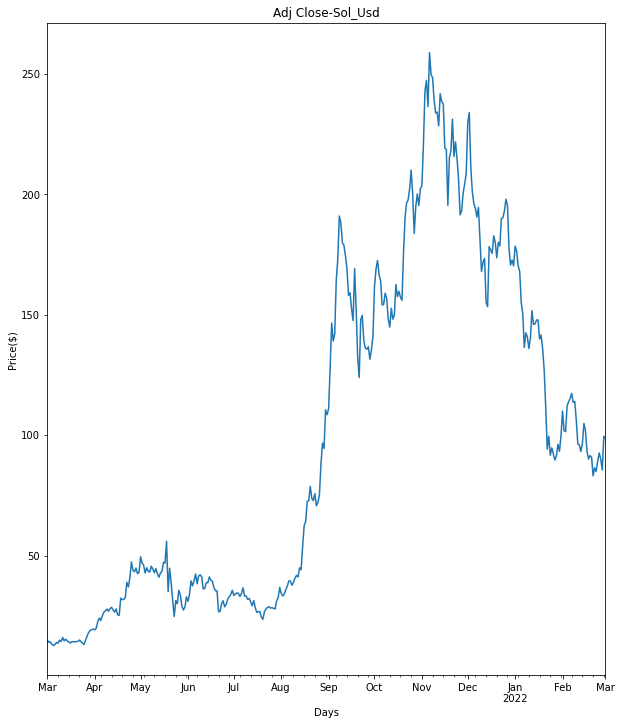

In [276]:
# Movement of VetChain between 01.03.2021-01.03.2022
data.plot(figsize=(10, 12))
import matplotlib.pyplot as plt
plt.title('Adj Close-Sol_Usd')
plt.xlabel('Days')
plt.ylabel('Price($)')


In [277]:
# Logarithmic Volatility
log_return = np.log(Sol_Usd['Adj Close'] / Sol_Usd['Adj Close'].shift(1))
log_return[:5]

Date
2021-03-01         NaN
2021-03-02   -0.068966
2021-03-03    0.011161
2021-03-04   -0.074822
2021-03-05   -0.037933
Name: Adj Close, dtype: float64

In [278]:
Sol_Usdvol = log_return.std() * np.sqrt(365)
print('The annualised volatility of Sol_Usd is', round(Sol_Usdvol*100,2), '%')

The annualised volatility of Sol_Usd is 143.46 %


In [279]:
# Binomial Tree Method

S0 =98.65 # dated 01-03-2022     # spot stock price
K = 85                          # strike
T = 1/52                        # maturity (1 month) 
r = 0.0172 # dated 01-03-2022     # risk free rate of return 
sigma = 1.43                      # Volatility 12 months
N = 3                            # number of periods or number of time steps
payoff = "put"             

In [280]:
dT = float(T) / N
u = np.exp(sigma * np.sqrt(dT))
d = 1 / u         # down factor 

In [281]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1
S

array([[ 98.65      , 110.61656617, 124.03471578, 139.08053062],
       [  0.        ,  87.9779841 ,  98.65      , 110.61656617],
       [  0.        ,   0.        ,  78.46047325,  87.9779841 ],
       [  0.        ,   0.        ,   0.        ,  69.97257241]])

In [282]:
a = np.exp(r * dT)    # risk-free rate (compounded)
p = (a - d)/ (u - d)  # up
q = 1 - p             # down
p

0.47188879850720244

In [283]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T - K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K - S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 15.02742759]])

In [284]:
for j in range(N - 1, -1, -1):
    for i in range(j + 1):
        V[i, j] = np.exp(- r * dT) * (p * V[i, j + 1] + q * V[i + 1, j + 1])
V

array([[ 2.21267246,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  4.19024711,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.93527788,  0.        ],
       [ 0.        ,  0.        ,  0.        , 15.02742759]])

In [285]:
print('European ' + payoff, str( V[0,0]))

European put 2.2126724591064626


In [329]:
# Monte Carlo Simulation Method
def mcs_simulation_np(m):  
    M = m     # m steps
    I = m     # m simulations
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S


In [330]:
S = mcs_simulation_np(10000)

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

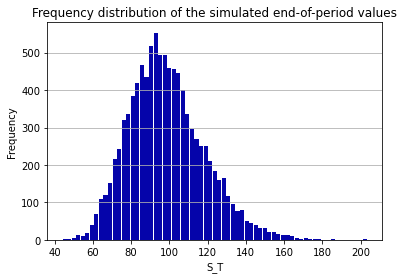

In [331]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[-1,:], bins='auto', color='#0504aa',alpha=1.0, rwidth=0.90)

plt.grid(axis='y', alpha=1.0)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

In [332]:
p = np.mean(np.maximum(K - S[:,-1],0))*np.exp(-r*T) 
print('Monte Carlo: European put', str(p))

Monte Carlo: European put 6.844789625702387


In [333]:
# BLACK-SCHOLES METHOD

import scipy.stats as si

In [334]:
def european_option_BS(S, K, T, r, sigma, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #sigma: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [335]:
pp = european_option_BS(98.65, 85, 1/52, 0.0172, 1.43, "put")
p

6.844789625702387

In [336]:
S = np.linspace(60,160,51)
pp = np.zeros((len(S),1))
for i in range(len(S)):
        pp[i] = european_option_BS(S[i], 85,0.0192,0.0172, 1.43, "put")
 

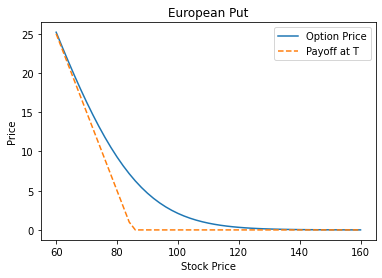

In [337]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(85-S,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

In [302]:
# ANALYSIS GREEKS
# Delta

S0 =98.65 # dated 01-03-2022     # spot stock price
K = 85                           # strike
T = 1/52                        # maturity (1 month) 
r = 0.0172 # dated 01-03-2022     # risk free rate of return 
vol = 1.43
q=0
payoff = 'put'

In [303]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(- q * T) * si.norm.cdf(- d1, 0.0, 1.0)
    
    return delta

In [206]:
delta(98.65, 85, 0.0192, 0.0172, 0, 1.43, "put")

-0.19701274423561393

In [207]:
S = np.linspace(60,160,51)
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
   Delta_Put [i] = delta(S[i], 85, 1/52, 0.0172, 0, 1.43, 'put')

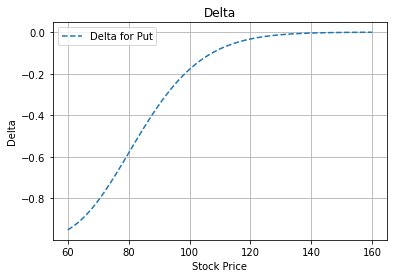

In [208]:
fig = plt.figure()
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

In [209]:
S = np.linspace(60,160,51)
T = np.linspace(1/365, 0.0192, 8)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 85, T[i], 0.0172, 0, 1.43, 'put')

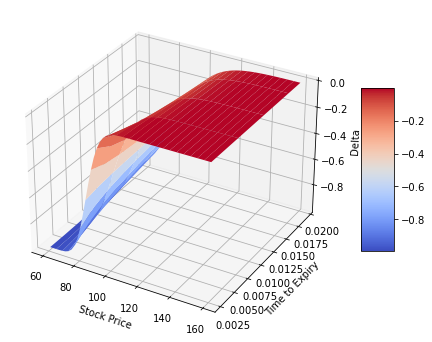

In [210]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [211]:
#Gamma

def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [212]:
gamma(98.65, 85, 0.0192, 0.0172, 0, 1.43, "put")

0.014188257842576366

In [213]:
S = np.linspace(60,160,51)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 85, 0.0192, 0.0172, 0, 1.43, "put")

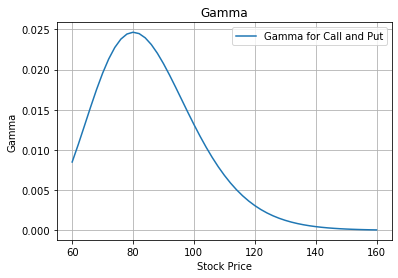

In [214]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [215]:
S = np.linspace(60,160,51)
T = np.linspace(1/365, 0.0192, 8)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 85, T[i],0.0172,0, 1.43, 'put')

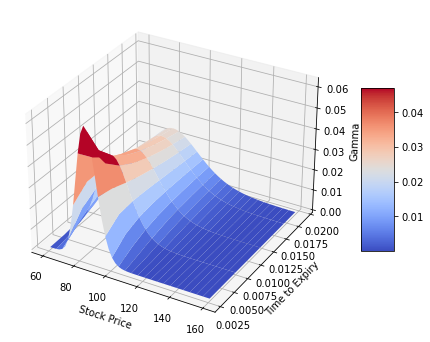

In [216]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [217]:
# THETA

def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [218]:
theta(98.65, 85, 0.0192, 0.0172, 0, 1.43, "put")

141.59894923006001

In [219]:
S = np.linspace(60,160,51)
Theta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Theta_Put[i] = theta(S[i], 85, 1/52, 0.0172, 0, 1.43, "put") 

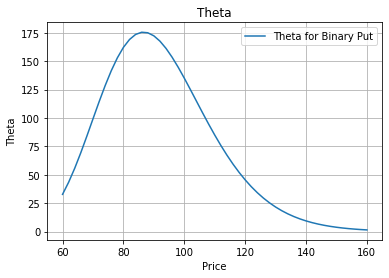

In [220]:
fig = plt.figure()
plt.plot(S, Theta_Put, '-')
plt.grid()
plt.xlabel('Price')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Binary Put'])

In [133]:
S = np.linspace(60,160,51)
T = np.linspace(1/365, 0.0192, 8)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 85, T[i], 0.0172, 0, 1.43, "put")

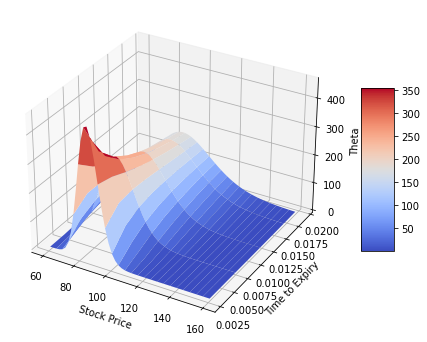

In [134]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [135]:
# SPEED

def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [136]:
speed(98.65, 85, 0.0192, 0.0172, 0, 1.43, "put")

-0.00010568901029478263

In [137]:
S = np.linspace(60,160,51)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 85, 0.0192, 0.0172, 0, 1.43, "put")

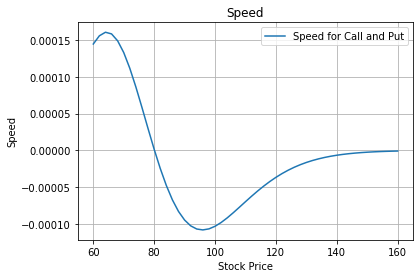

In [138]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

In [139]:
S = np.linspace(60,160,51)
T = np.linspace(1/365, 0.0192, 8)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 85, T[i], 0.0172, 0, 1.43, 'call')


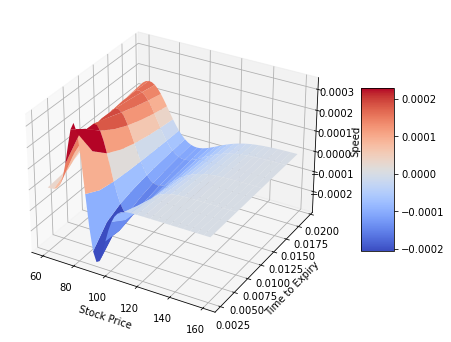

In [140]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [235]:
# VEGA

def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [236]:
vega(98.65, 85, 0.0192, 0.0172, 0, 1.43, "put")

3.7923109412673734

In [237]:
vol = np.linspace(0.5,2,11)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(98.65, 85, 0.0192, 0.0172, 0,vol[i],'put')

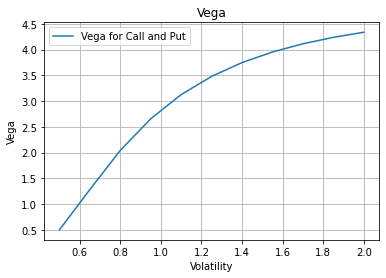

In [238]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [239]:
S = np.linspace(60,160,51)
T = np.linspace(1/365, 0.0192, 8)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j],  85, 0.0192, 0.0172, 0,vol[i],'put')

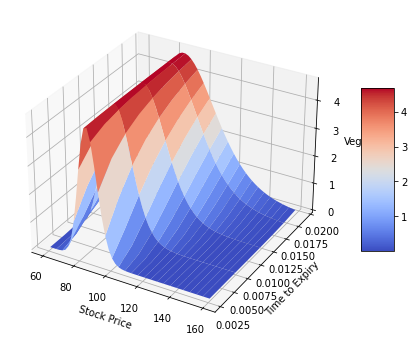

In [240]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [147]:
# RHO

def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [148]:
rho (98.65, 85, 0.0192, 0.0172, 0, 1.43, "put")

-0.4184594308709527

In [149]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(98.65, 85, 0.0192, r[i],0, 1.43,'call')
    Rho_Put [i] = rho(98.65, 85, 0.0192, r[i],0, 1.43, 'put')

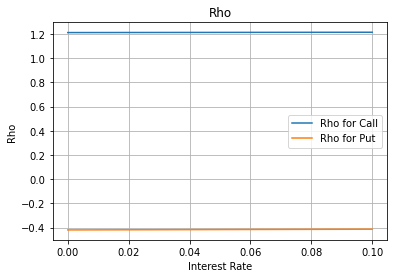

In [150]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

In [151]:
S = np.linspace(60,160,51)
T = np.linspace(1/365, 0.0192, 8)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 85, T[i],  0.0172, 0, 1.43, "put")

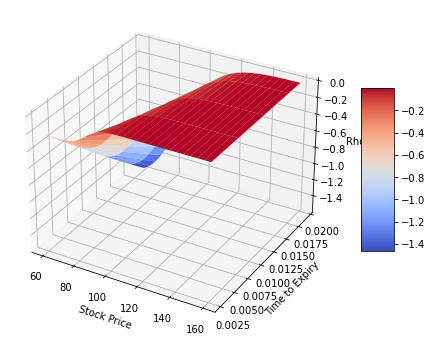

In [152]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);